# Tarea 1

## Introducción a la Ciencia de Datos 2025

### Ignacio Campón & Mauro Loprete

In [4]:
from time import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

from collections import Counter
from nltk.corpus import stopwords

import nltk

## Parte 1: Cargado y Limpieza de datos

In [ ]:
df_speeches = pd.read_csv('../data/us_2020_election_speeches.csv')
df_speeches["date"] = pd.to_datetime(df_speeches["date"])

df_speeches

                   speaker                                              title  \
0             David Perdue  Georgia Sen. David Perdue Speech Transcript at...   
1                Joe Biden  Joe Biden Southfield, MI Speech on Health Care...   
2             Donald Trump  Donald Trump Speech Transcript ‘Protecting Ame...   
3                Joe Biden      Joe Biden ABC Town Hall Transcript October 15   
4             Donald Trump   Donald Trump NBC Town Hall Transcript October 15   
..                     ...                                                ...   
264         Bernie Sanders  Bernie Sanders Speech Transcript: Sanders Spea...   
265  Democratic Candidates  Transcript: Speeches at the Iowa Caucuses – Be...   
266           Donald Trump  Donal Trump Iowa Rally Transcript: Trump Holds...   
267           Donald Trump  Donald Trump New Jersey Rally Speech Transcrip...   
268  Democratic Candidates          January Iowa Democratic Debate Transcript   

                           

# A) Datos faltantes

Hacemos uso de las funciones len() y el atributo count() para obtener los datos faltantes por variable en el dataframe df_speeches

In [ ]:
n = len(df_speeches)
count = df_speeches.count()
n-count

print(df_speeches[df_speeches["title"]=="Mike Pence Campaign Speech Miami Transcript October 15"])



      speaker                                              title  \
6  Mike Pence  Mike Pence Campaign Speech Miami Transcript Oc...   

                                                text       date  \
6  Pedro Fuentes Cid: (01:08)\nYeah, my name is P... 2020-10-15   

         location             type  
6  Miami, Florida  Campaign Speech  


In [22]:
# select numerical columns
df_speeches.dtypes

speaker             object
title               object
text                object
date        datetime64[ns]
location            object
type                object
dtype: object

In [23]:
def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

print_categories(df_speeches)

speaker :  Categorical
title :  Text (Unique)
text :  Text (Unique)
date :  Date
location :  Categorical
type :  Categorical


In [9]:
df_speeches.describe()

,speaker,title,text,date,location,type
count,266,269,269,269,251,248
unique,71,269,269,123,102,9
top,Joe Biden,January Iowa Democratic Debate Transcript,"Wolf Blitzer: (00:00)\nAll right, so let’s beg...","Aug 27, 2020",Virtual,Campaign Speech
freq,71,1,1,9,62,180


In [10]:
# how many types and obs are?
df_speeches["type"].value_counts()

type
Campaign Speech       180
Town Hall              18
Interview              14
Debate                  9
Endorsement             8
Statement               8
Roundtable              8
Press Conference        2
Voter Mobilization      1
Name: count, dtype: int64

In [40]:
# filter campaign speeches
speeches = df_speeches[df_speeches["type"] == "Campaign Speech"]

# group speeches by speaker
#speeches["speaker"].value_counts()

speeches.groupby(["date", "speaker"]).value_counts()


date        speaker                title                                                                                                                                      text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:

top5_speakers = speeches["speaker"].value_counts().head(5).index
top_speeches = speeches[speeches["speaker"].isin(top5_speakers)]

df_speeches["month"] = df_speeches["date"].dt.to_period("M").value_counts()


KeyError: "None of [Index([nan, nan, nan, nan, nan], dtype='float64')] are in the [columns]"

# B) Gráfica para visualizar discursos de los candidatos por año

C:\Users\campo\AppData\Local\Temp\ipykernel_1612\3518350441.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["CleanText"] = clean_text(top_speeches, "text")
C:\Users\campo\AppData\Local\Temp\ipykernel_1612\3518350441.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["month"] = top_speeches["date"].dt.to_period("M")
C:\Users\campo\AppData\Local\Temp\ipykernel_1612\3518350441.py:34: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.


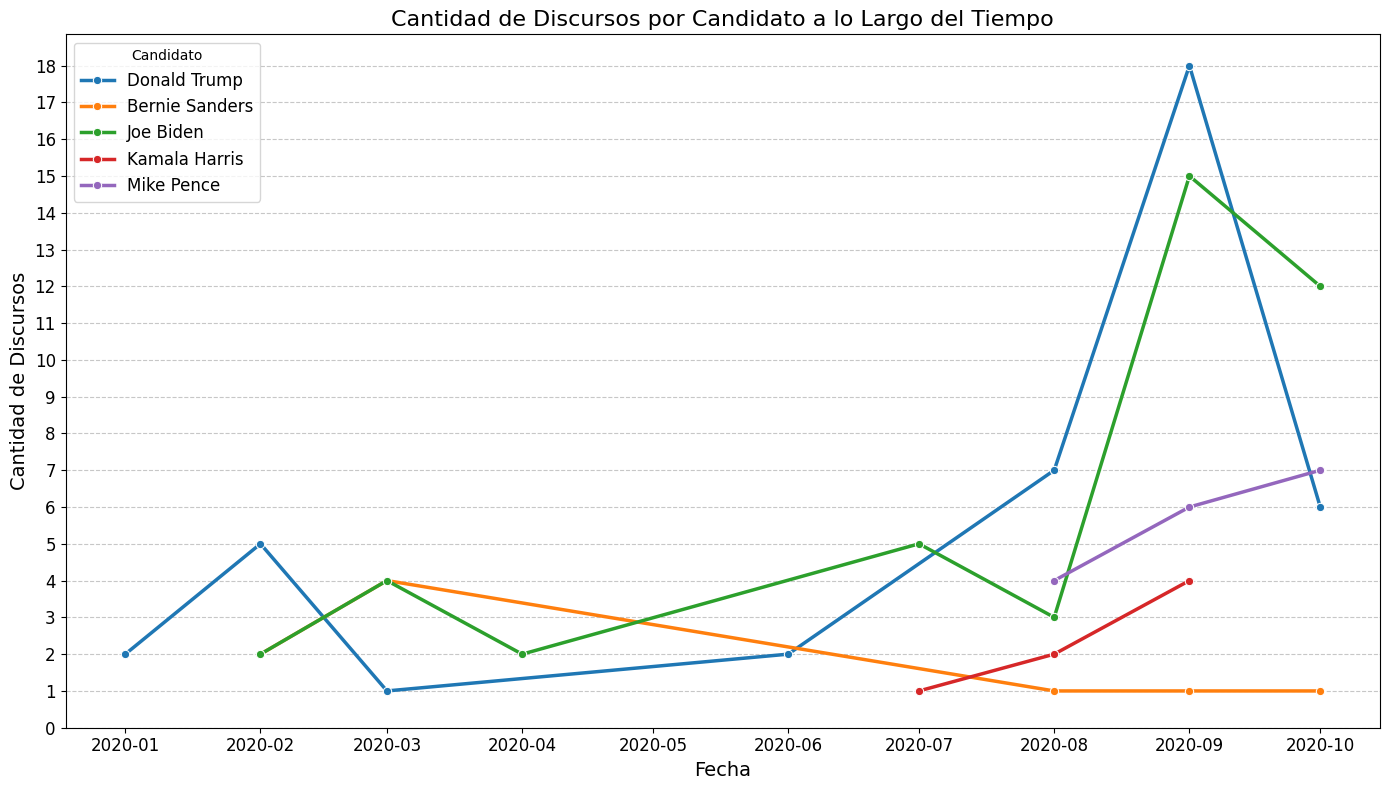

In [ ]:
def clean_text(df, column_name):
    # eliminamos primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    
    # convertir a minusculas
    result = result.str.lower()
    
    # eliminar caracteres especiales
    for punc in ["[", "]", "\n", ",", ":", "?", ".", "!", ";", "\"", "\'"]:
        result = result.str.replace(punc, " ", regex=False)
    
    # eliminar espacios extras
    result = result.str.replace(r"\s+", " ", regex=True).str.strip()
    
    return result

# creamos columna clentext
top_speeches["CleanText"] = clean_text(top_speeches, "text")

# verificar si hay valores nulos después de la conversión
if top_speeches["date"].isnull().any():
    print("Advertencia: Hay valores nulos en la columna 'date' después de la conversión.")

# agrupamos por mes y por candidato
top_speeches["month"] = top_speeches["date"].dt.to_period("M")
top_speeches_grouped = top_speeches.groupby(["month", "speaker"]).size().reset_index(name="count")

# Convertir el período a una fecha para el gráfico
top_speeches_grouped["month"] = top_speeches_grouped["month"].dt.to_timestamp()

custom_palette = sns.color_palette("tab10") 

plt.figure(figsize=(14, 8))
sns.lineplot(data=top_speeches_grouped, x="month", y="count", hue="speaker", marker="o", palette=custom_palette, linewidth=2.5)
plt.title("Cantidad de Discursos por Candidato a lo Largo del Tiempo", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Cantidad de Discursos", fontsize=14)
plt.legend(title="Candidato", fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(range(0, np.max(top_speeches_grouped["count"]) + 1, 1), fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

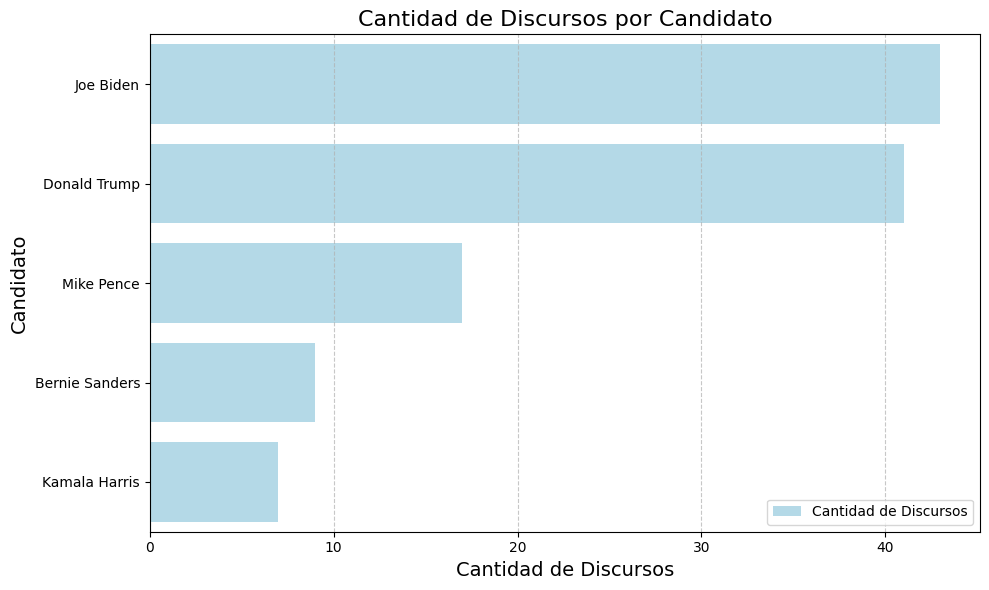

In [ ]:
# creamos grafico complementario para visualizar discursos por candidato
# agrupamos por candidato
lollipop_data = top_speeches.groupby("speaker").size().reset_index(name="count")

# reordenamos
lollipop_data = lollipop_data.sort_values(by="count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=lollipop_data, x="count", y="speaker", color="skyblue", alpha=0.7, label="Cantidad de Discursos")

plt.title("Cantidad de Discursos por Candidato", fontsize=16)
plt.xlabel("Cantidad de Discursos", fontsize=14)
plt.ylabel("Candidato", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\campo\AppData\Local\Temp\ipykernel_1612\3883230996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["date"] = pd.to_datetime(top_speeches["date"], errors="coerce")
C:\Users\campo\AppData\Local\Temp\ipykernel_1612\3883230996.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["bimester"] = top_speeches["date"].apply(assign_bimester)


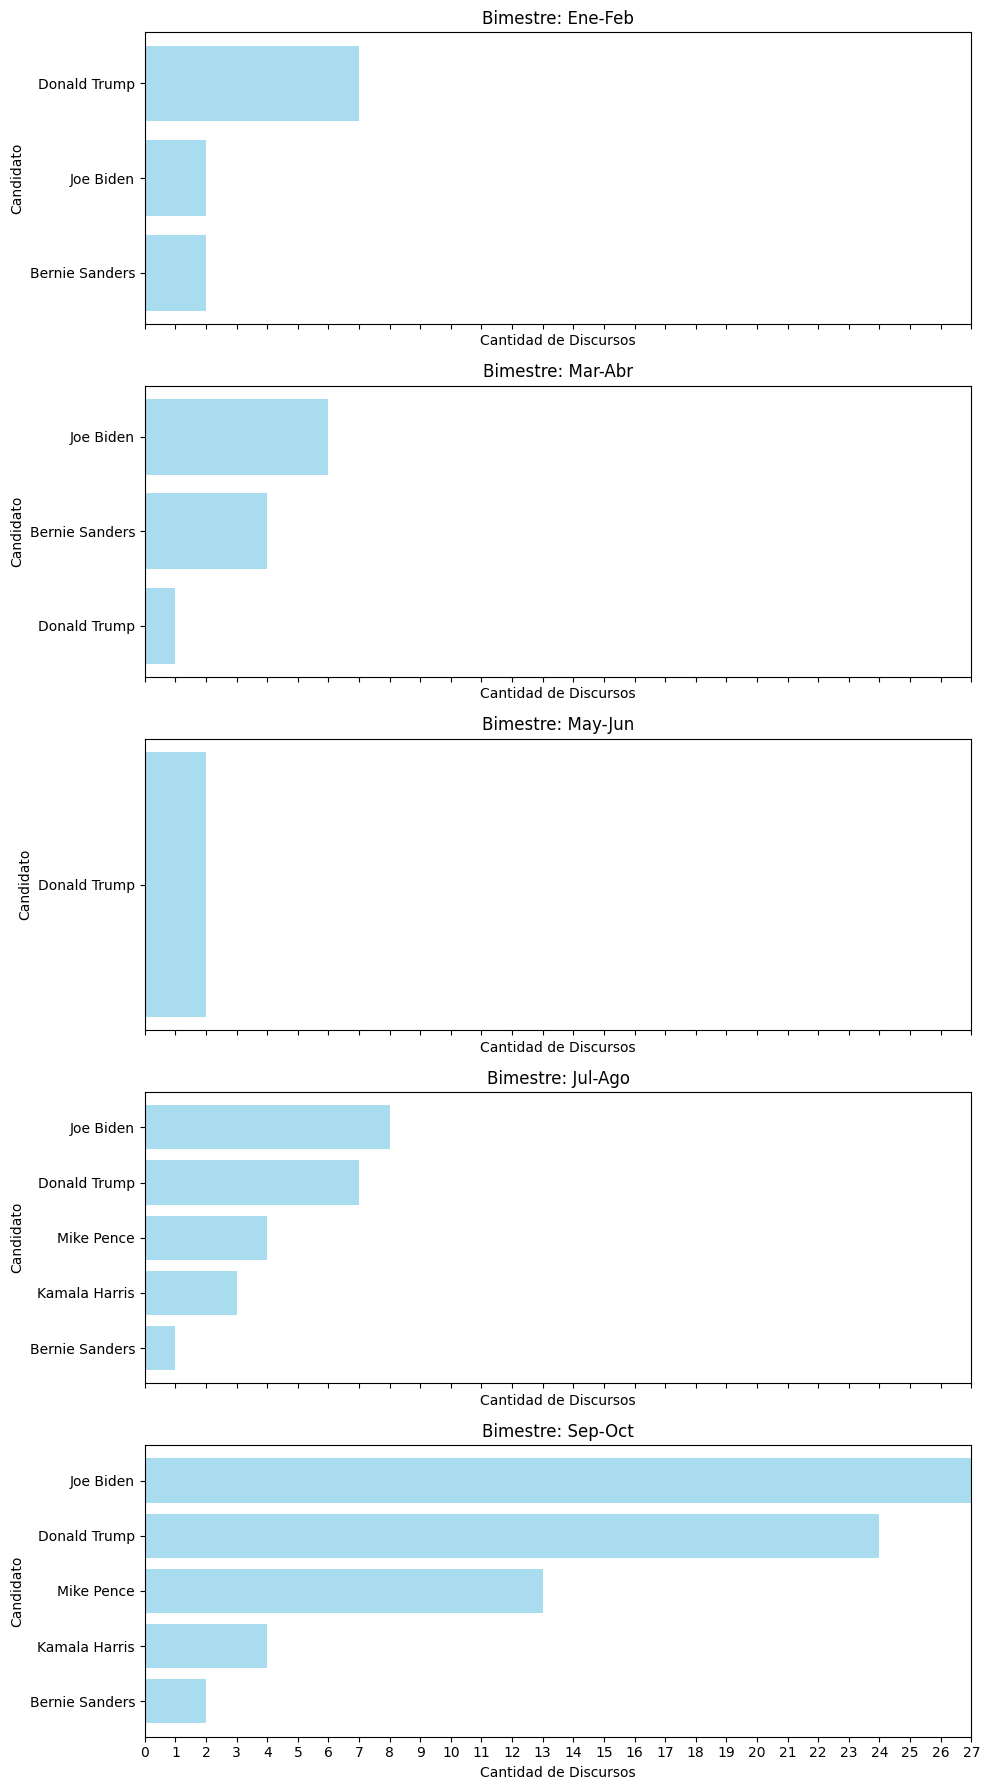

In [36]:


# Asegurar que la columna 'date' esté en formato datetime
top_speeches["date"] = pd.to_datetime(top_speeches["date"], errors="coerce")

# Crear una función para asignar cada fecha a su bimestre correspondiente
def assign_bimester(date):
    month = date.month
    if month in [1, 2]:
        return "Ene-Feb"
    elif month in [3, 4]:
        return "Mar-Abr"
    elif month in [5, 6]:
        return "May-Jun"
    elif month in [7, 8]:
        return "Jul-Ago"
    elif month in [9, 10]:
        return "Sep-Oct"
    else:
        return "Nov-Dic"  # Opcional, si hay datos en nov-dic

# Crear nueva columna de bimestre
top_speeches["bimester"] = top_speeches["date"].apply(assign_bimester)

# Agrupar los datos por bimestre y candidato
bimester_data = top_speeches.groupby(["bimester", "speaker"]).size().reset_index(name="count")

# Ordenar bimestres manualmente
ordered_bimesters = ["Ene-Feb", "Mar-Abr", "May-Jun", "Jul-Ago", "Sep-Oct"]
bimester_data["bimester"] = pd.Categorical(bimester_data["bimester"], categories=ordered_bimesters, ordered=True)
bimester_data = bimester_data.sort_values(["bimester", "count"], ascending=[True, False])

# Crear subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 18), sharex=True)

for i, bim in enumerate(ordered_bimesters):
    ax = axes[i]
    data = bimester_data[bimester_data["bimester"] == bim].sort_values(by="count", ascending=True)
    
    ax.barh(data["speaker"], data["count"], color="skyblue", alpha=0.7)
    ax.set_title(f"Bimestre: {bim}")
    ax.set_xlabel("Cantidad de Discursos")
    ax.set_ylabel("Candidato")
    ax.set_xlim(left=0)
    ax.set_xticks(np.arange(0, data["count"].max() + 1))

plt.tight_layout()
plt.show()

# Parte C) Limpieza de texto

In [48]:
def clean_text(df, column_name):
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    
    # Convertir todo a minúsculas
    result = result.str.lower()
    
    # Eliminar signos de puntuación y caracteres no deseados
    for punc in ["[", "]", "\n", ",", ":", "?", ".", "!", ";", "\"", "\'"]:
        result = result.str.replace(punc, " ", regex=False)
    
    # Eliminar espacios extra
    result = result.str.replace(r"\s+", " ", regex=True).str.strip()
    
    return result

# Crear la columna CleanText
top_speeches["CleanText"] = clean_text(top_speeches, "text")




/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1298669112.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mauroloprete/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1404019355.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1404019355.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



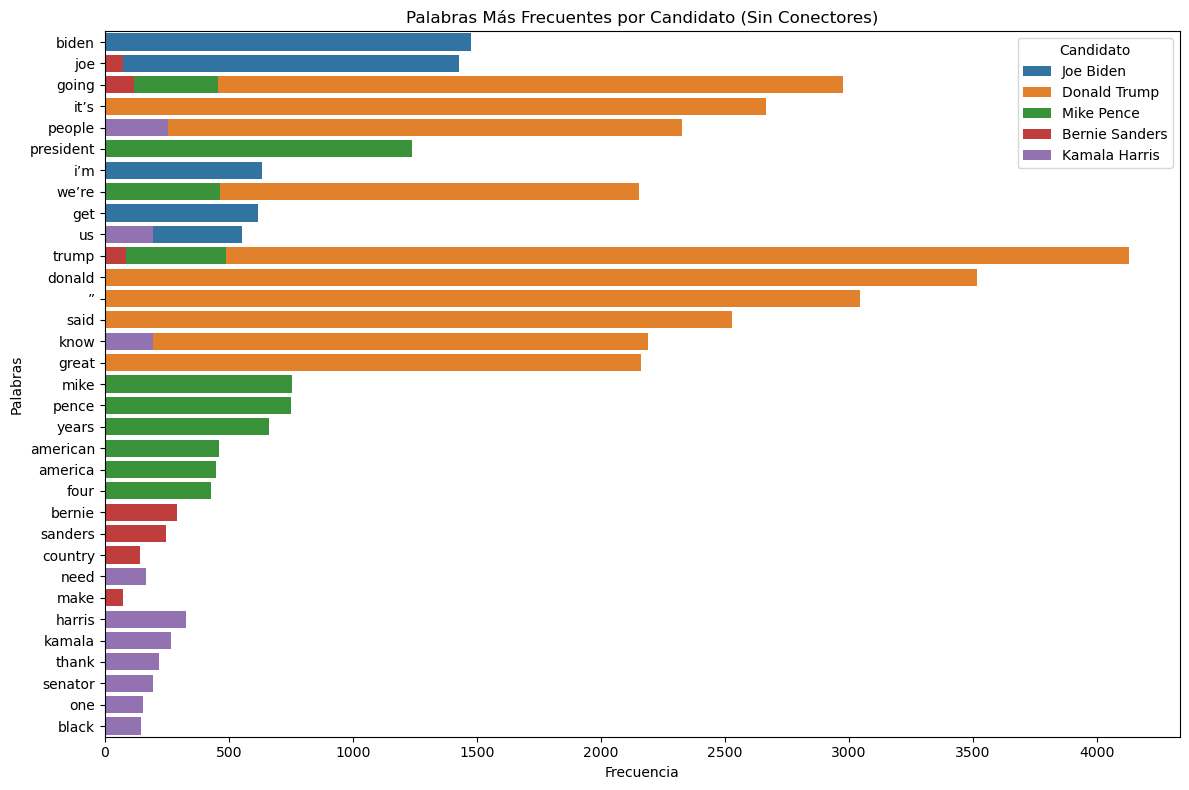

In [ ]:

# Descargar stopwords si es necesario
nltk.download('stopwords')

# Crear una lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

# Crear la columna WordList si no existe
if "WordList" not in top_speeches.columns:
    top_speeches["WordList"] = top_speeches["CleanText"].str.split()

# Filtrar las palabras eliminando las stopwords
top_speeches["FilteredWordList"] = top_speeches["WordList"].apply(
    lambda words: [word for word in words if word not in stop_words]
)

# Contar palabras por candidato
word_counts = {}
for speaker in top_speeches["speaker"].unique():
    all_words = top_speeches[top_speeches["speaker"] == speaker]["FilteredWordList"].explode()
    word_counts[speaker] = Counter(all_words)

# Crear un DataFrame con las palabras más frecuentes
top_words = pd.DataFrame([
    {"speaker": speaker, "word": word, "count": count}
    for speaker, counts in word_counts.items()
    for word, count in counts.most_common(10)
])

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words, x="count", y="word", hue="speaker", dodge=False)
plt.title("Palabras Más Frecuentes por Candidato (Sin Conectores)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.legend(title="Candidato")
plt.tight_layout()
plt.show()

# TODO: Ordenar todo esto y redactar (Es de la parte 2)

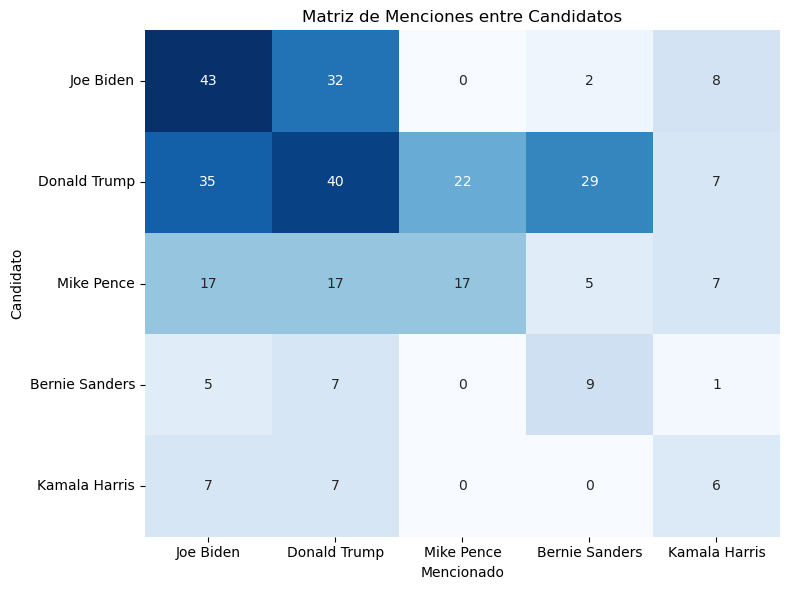

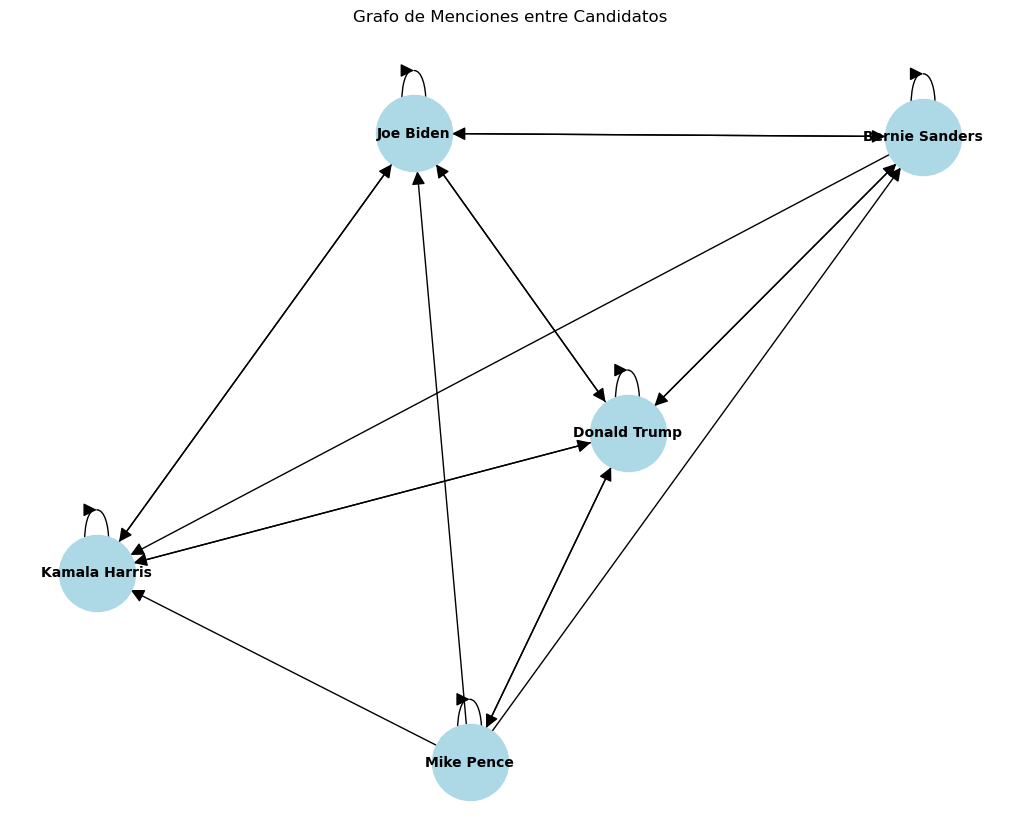

In [ ]:
candidates = top_speeches["speaker"].unique()
mentions_matrix = pd.DataFrame(0, index=candidates, columns=candidates)

# Menciones entre candidatos (sin contar a sí mismos) # FIX: si menciona a mas de uno se cuenta en cada candidato
for speaker in candidates:
    for mentioned in candidates:
        mentions_matrix.loc[speaker, mentioned] = top_speeches[
            (top_speeches["speaker"] == speaker) & 
            (top_speeches["CleanText"].str.contains(mentioned, case=False))
        ].shape[0]

# Visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(mentions_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Menciones entre Candidatos")
plt.xlabel("Mencionado")
plt.ylabel("Candidato")
plt.tight_layout()
plt.show()



In [ ]:
# Crear un grafo dirigido
G = nx.from_pandas_adjacency(mentions_matrix, create_using=nx.DiGraph)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("Grafo de Menciones entre Candidatos")
plt.show()